# Table of Contents
 <p><div class="lev2 toc-item"><a href="#数据降维" data-toc-modified-id="数据降维-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>数据降维</a></div><div class="lev2 toc-item"><a href="#缺失值处理" data-toc-modified-id="缺失值处理-02"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>缺失值处理</a></div><div class="lev2 toc-item"><a href="#异常值处理" data-toc-modified-id="异常值处理-03"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>异常值处理</a></div><div class="lev2 toc-item"><a href="#数据规约" data-toc-modified-id="数据规约-04"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>数据规约</a></div><div class="lev2 toc-item"><a href="#建模" data-toc-modified-id="建模-05"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>建模</a></div>

1. <b>Understand the problem</b>. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
2. <b>Univariable study</b>. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
3. <b>Multivariate study</b>. We'll try to understand how the dependent variable and independent variables relate.
4. <b>Basic cleaning</b>. We'll clean the dataset and handle the missing data, outliers and categorical variables.
5. <b>Test assumptions</b>. We'll check if our data meets the assumptions required by most multivariate techniques.

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [155]:
df_train = pd.read_csv('train.csv', encoding='utf-8')
df_train.shape

(1460, 81)

In [156]:
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

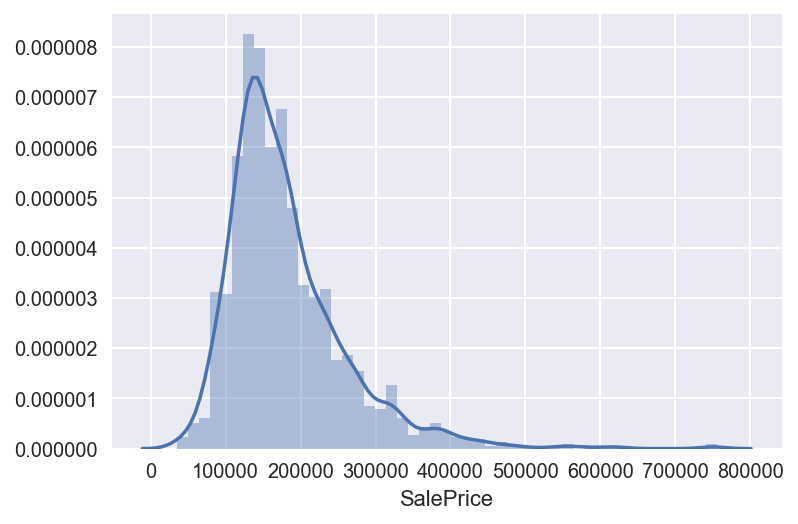

In [157]:
sns.distplot(df_train.SalePrice)

In [158]:
print ('Skewness: %f' % df_train.SalePrice.skew())
print ('Kurtosis: %f' % df_train.SalePrice.kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## 数据降维

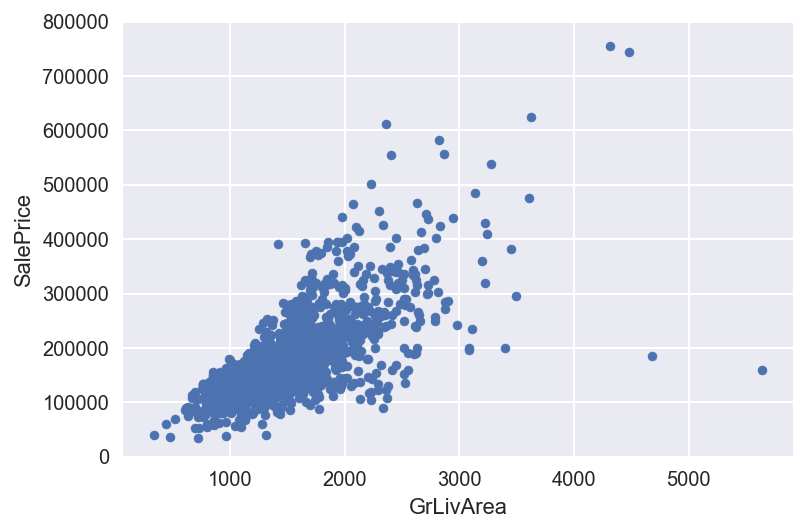

In [159]:
var = 'GrLivArea'
data = pd.concat([df_train.SalePrice, df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

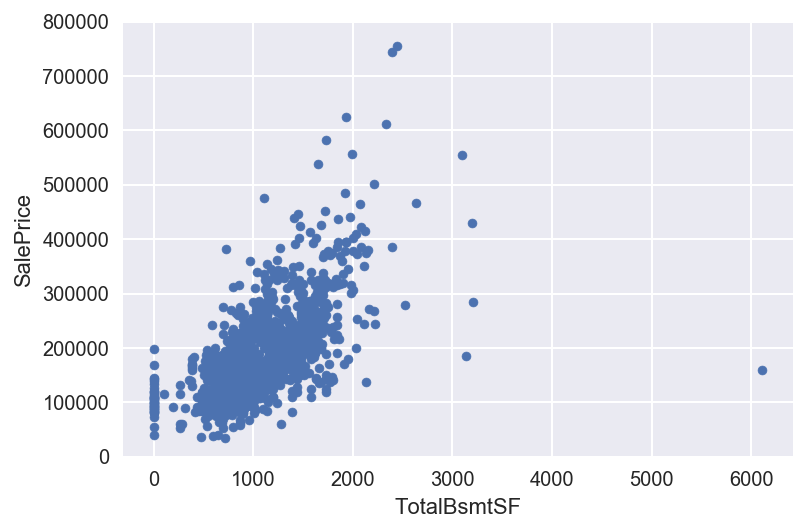

In [160]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

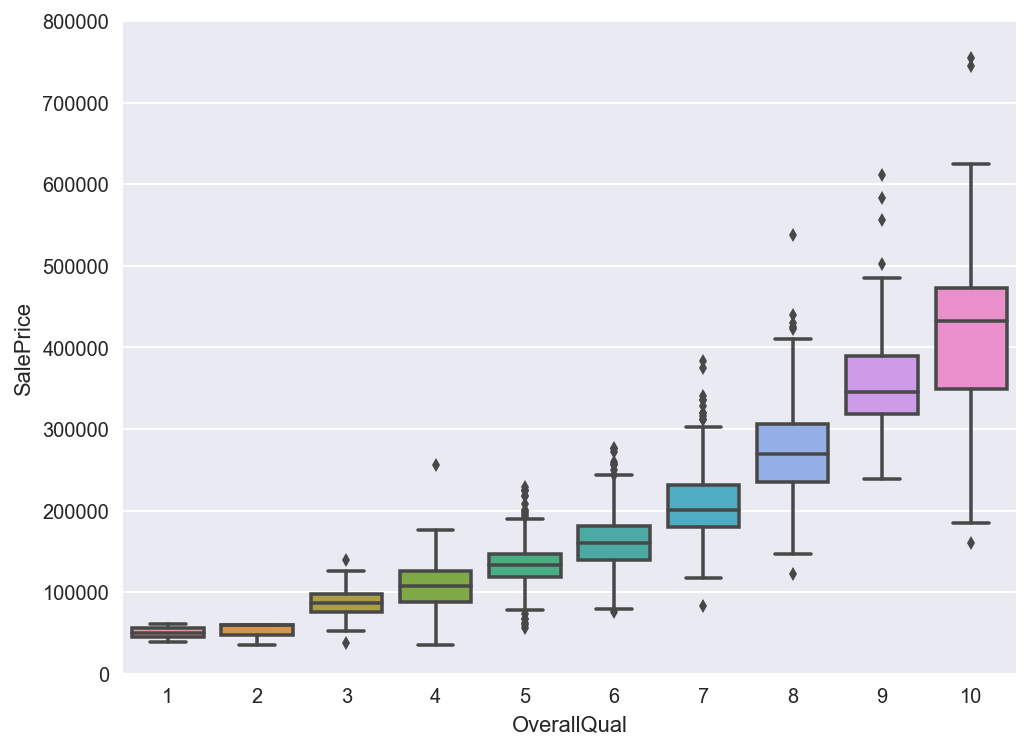

In [161]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

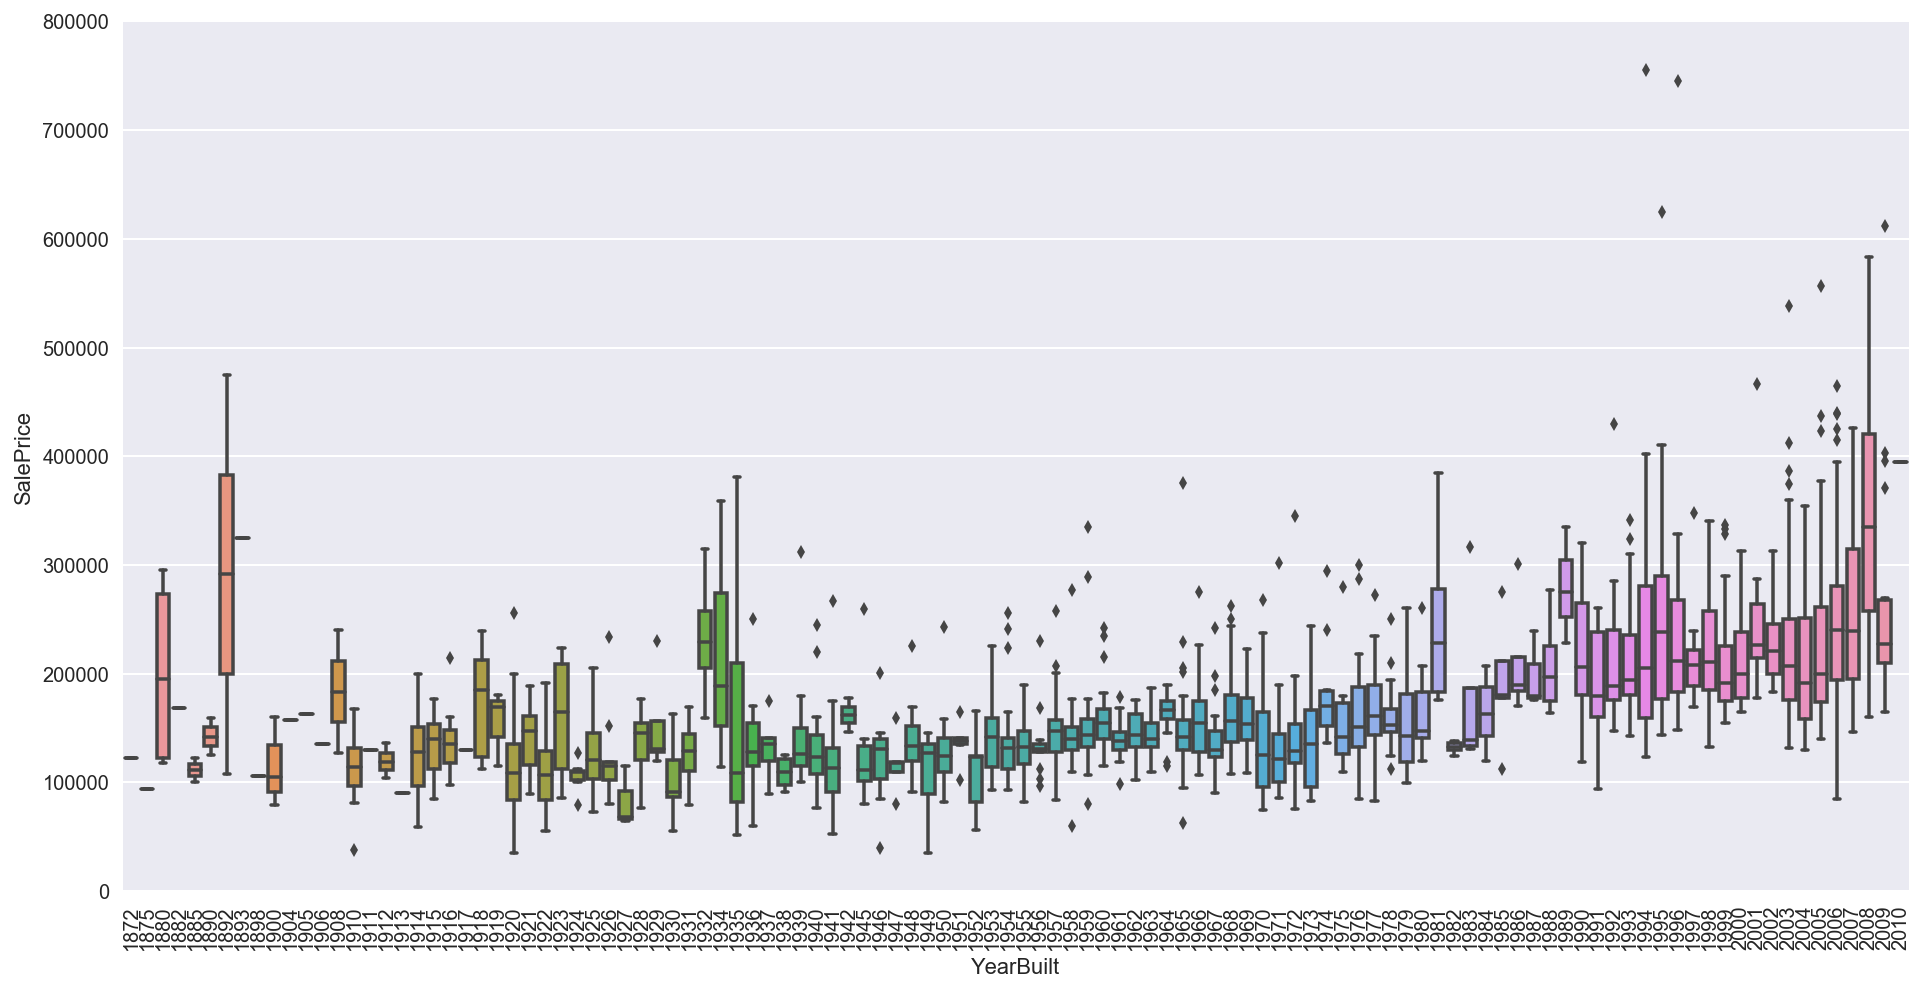

In [162]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

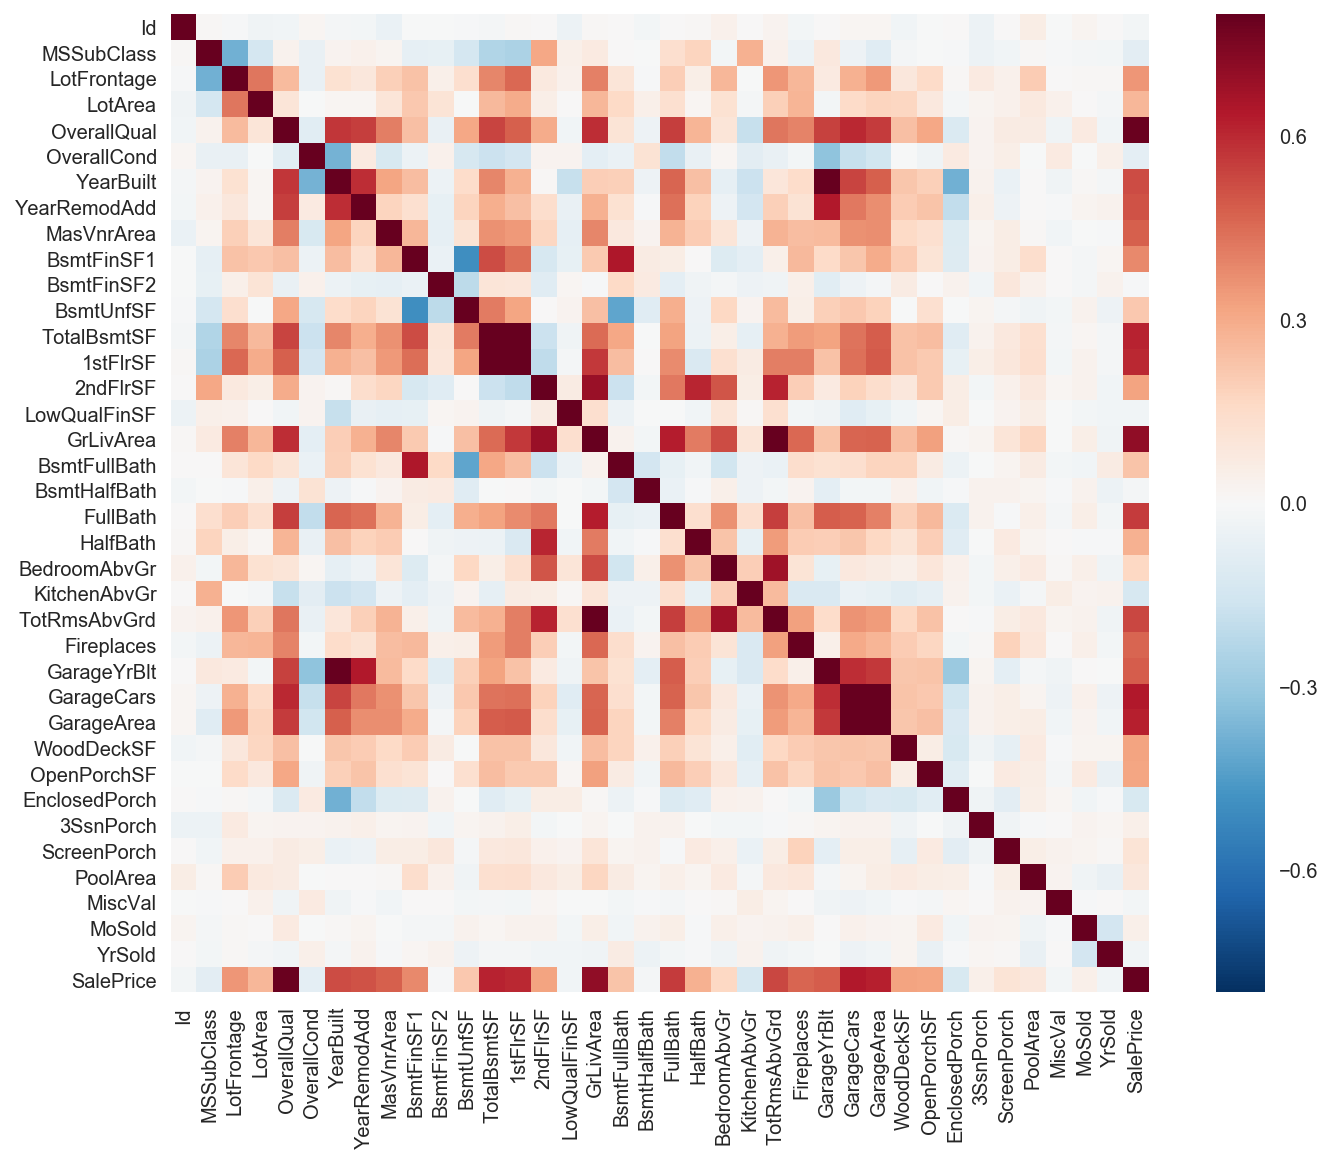

In [163]:
# 相关性矩阵
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

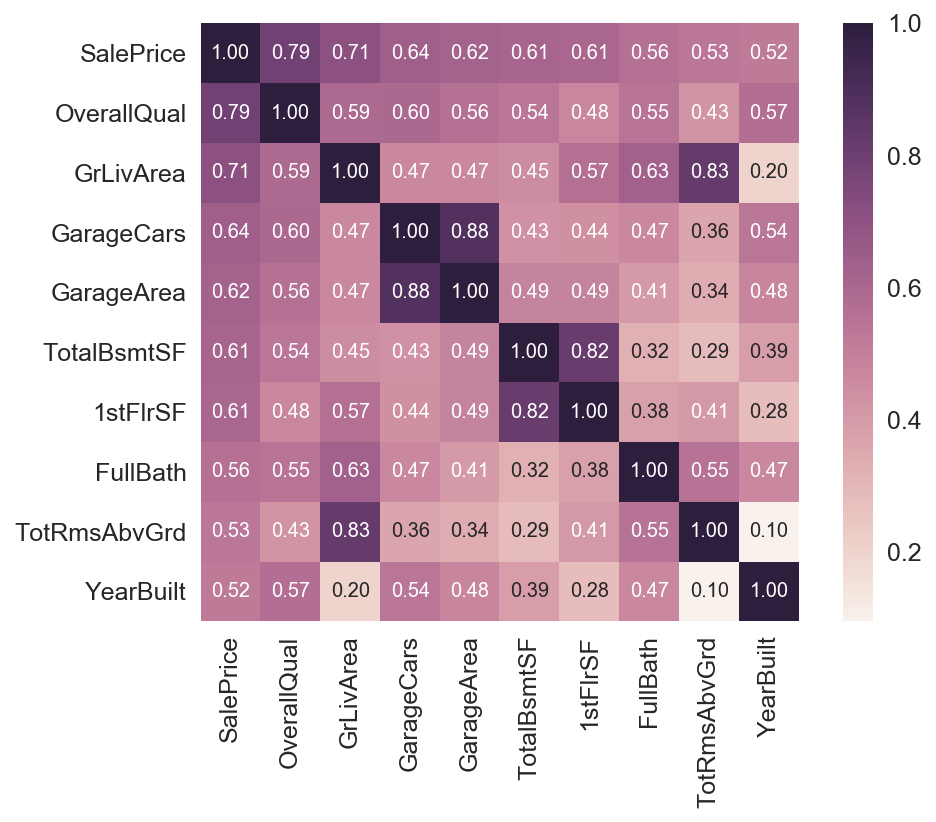

In [164]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                annot_kws={'size': 10}, yticklabels=cols.values,
                xticklabels=cols.values)
plt.show()

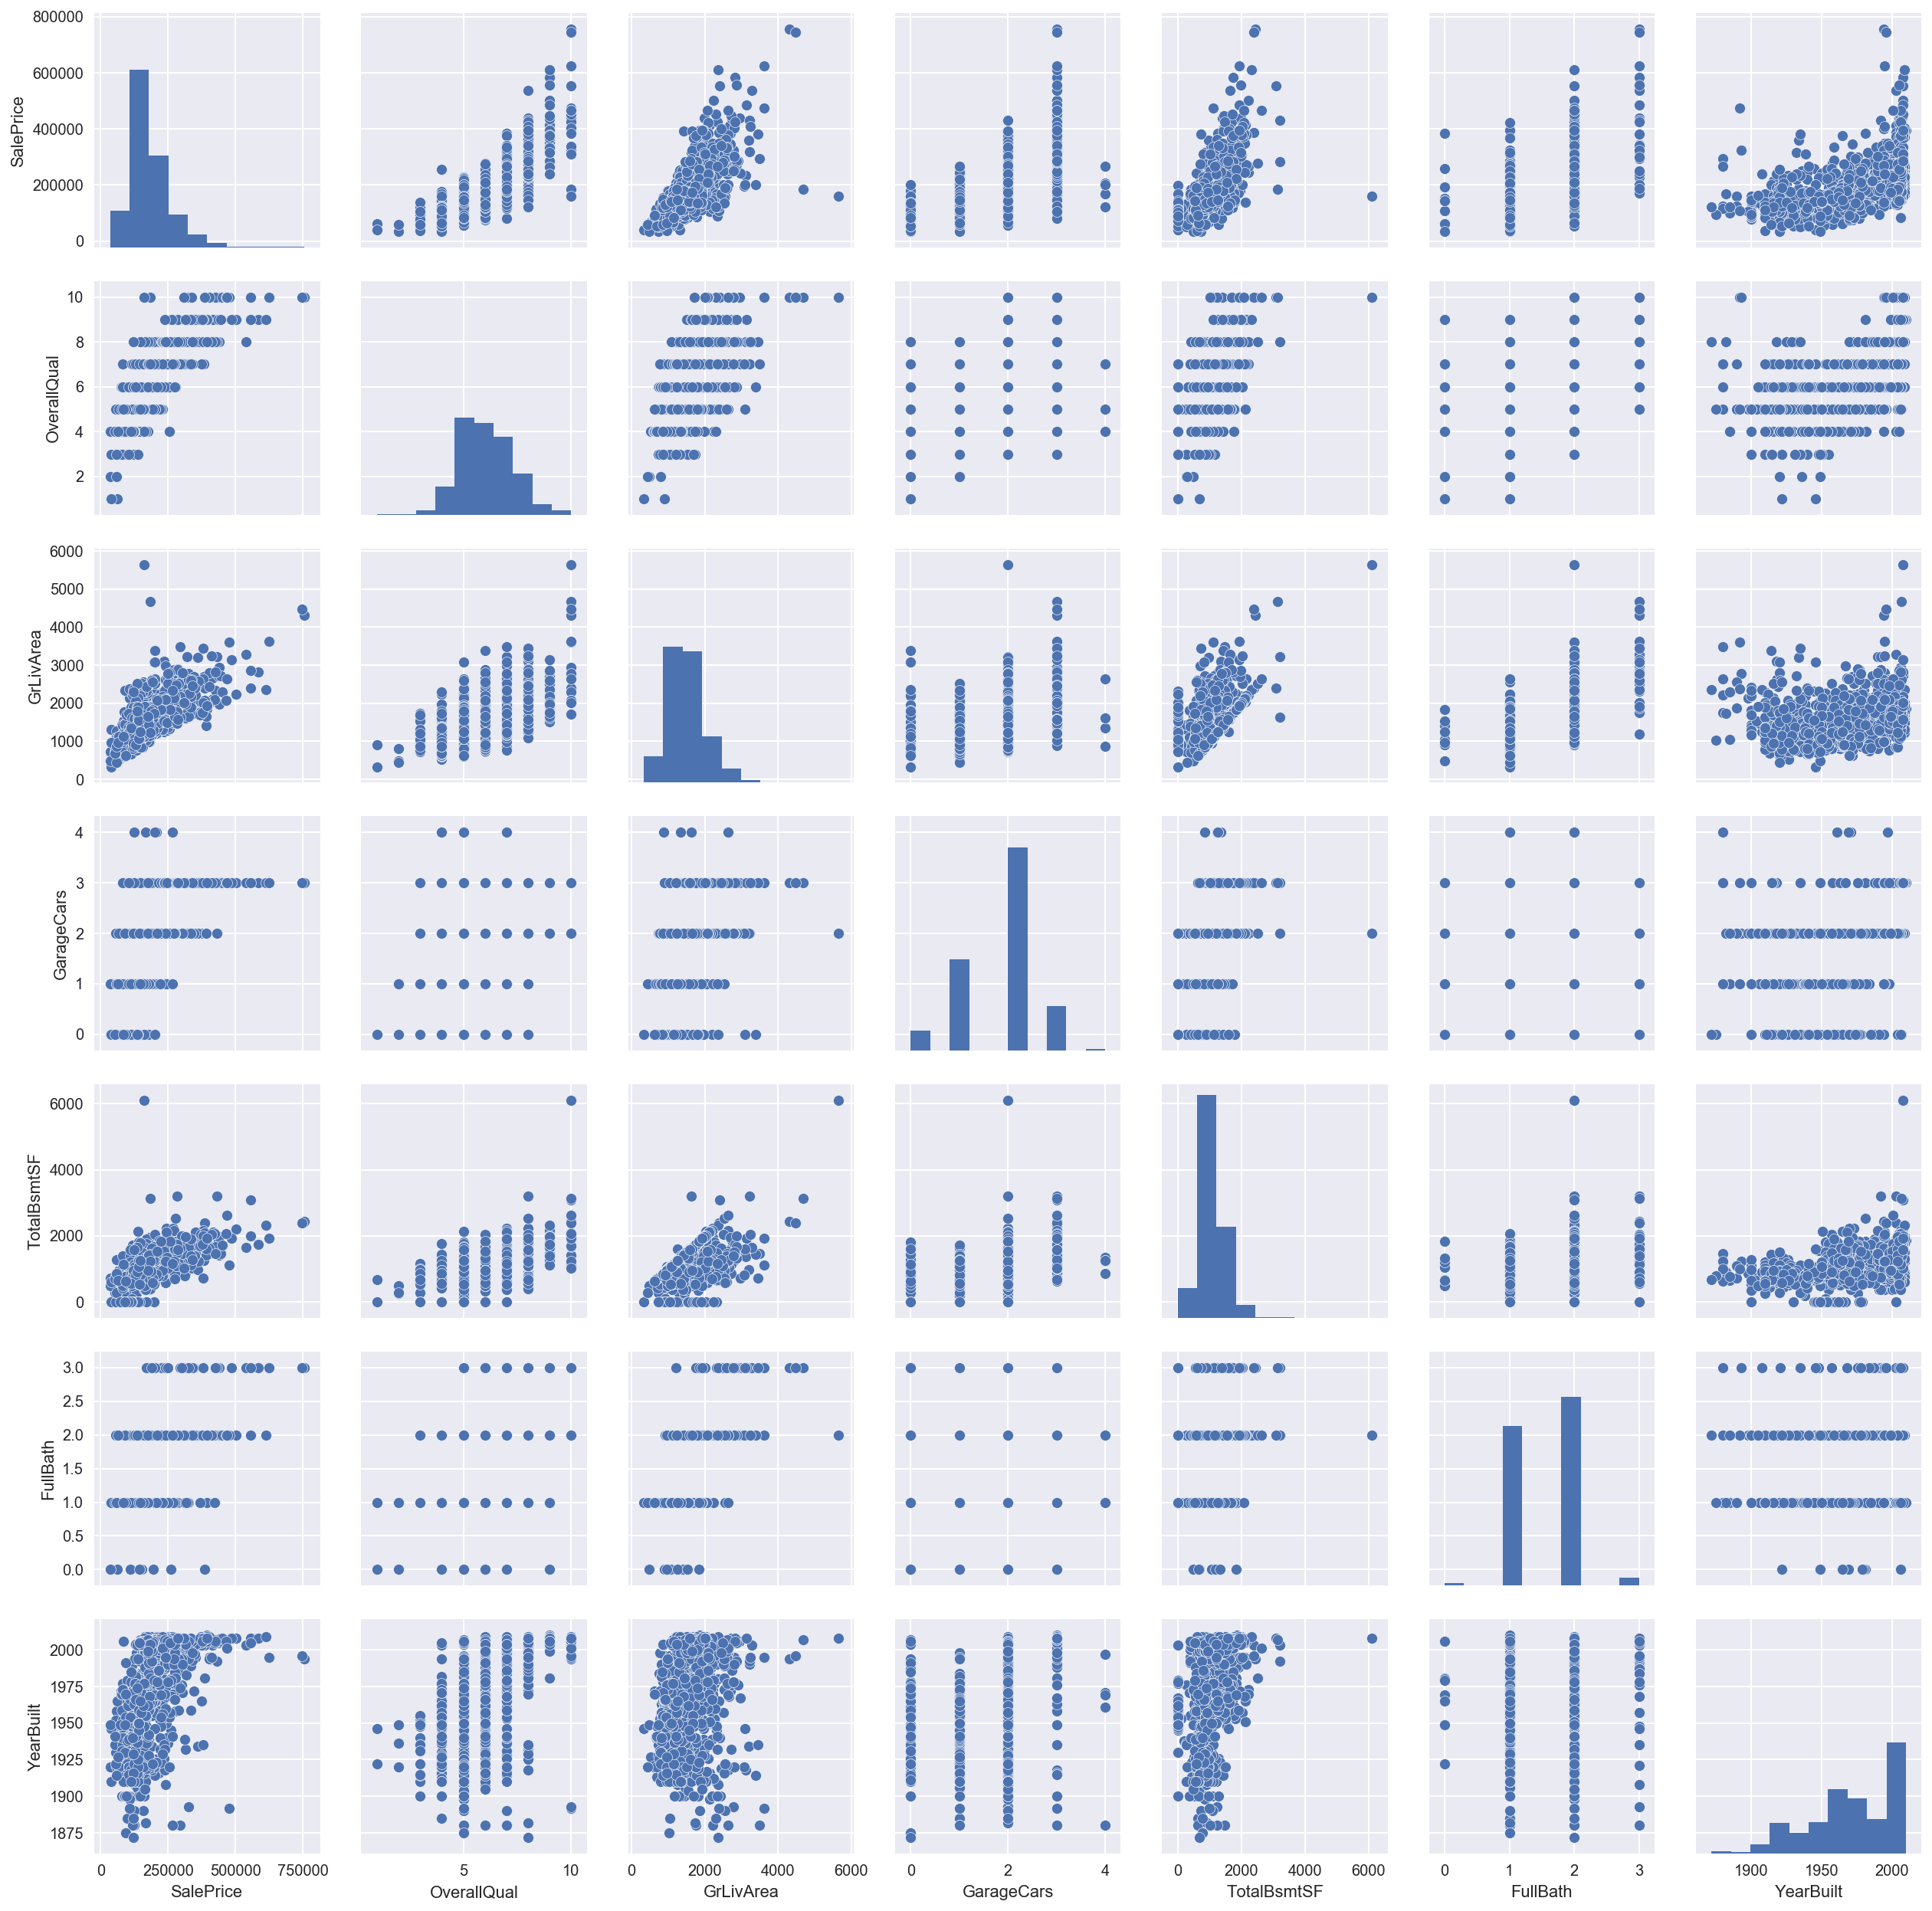

In [165]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',
        'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size=2.5)
plt.show()

## 缺失值处理

In [166]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
# .count() 不为空的数据数量
# .isnull().count() 包括空的数据数量

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [167]:
df_train = df_train.drop((missing_data[missing_data.Total > 1]).index, 1)
df_train = df_train.drop(df_train.loc[df_train.Electrical.isnull()].index)
df_train.isnull().sum().max()

0

## 异常值处理

In [168]:
# 标准化数据
saleprice_scaled = StandardScaler().fit_transform(df_train.SalePrice[:, np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


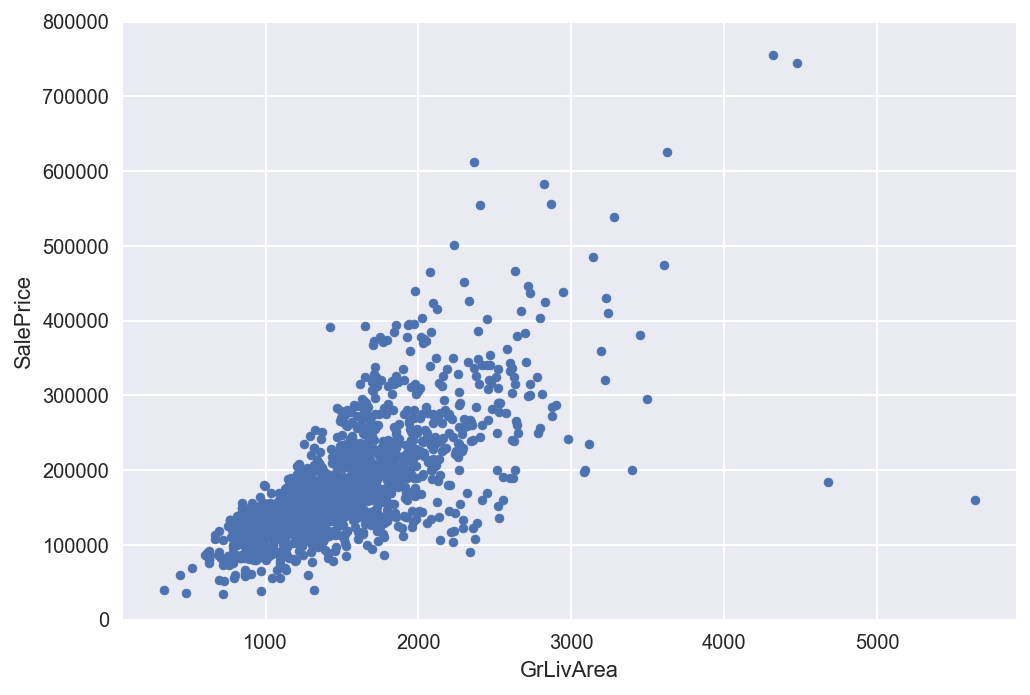

In [169]:
var = 'GrLivArea'
data = pd.concat([df_train.SalePrice, df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [170]:
df_train.sort_values(by='GrLivArea', ascending=False)[:2]
df_train = df_train.drop(df_train[df_train.Id == 1299].index)
df_train = df_train.drop(df_train[df_train.Id == 524].index)

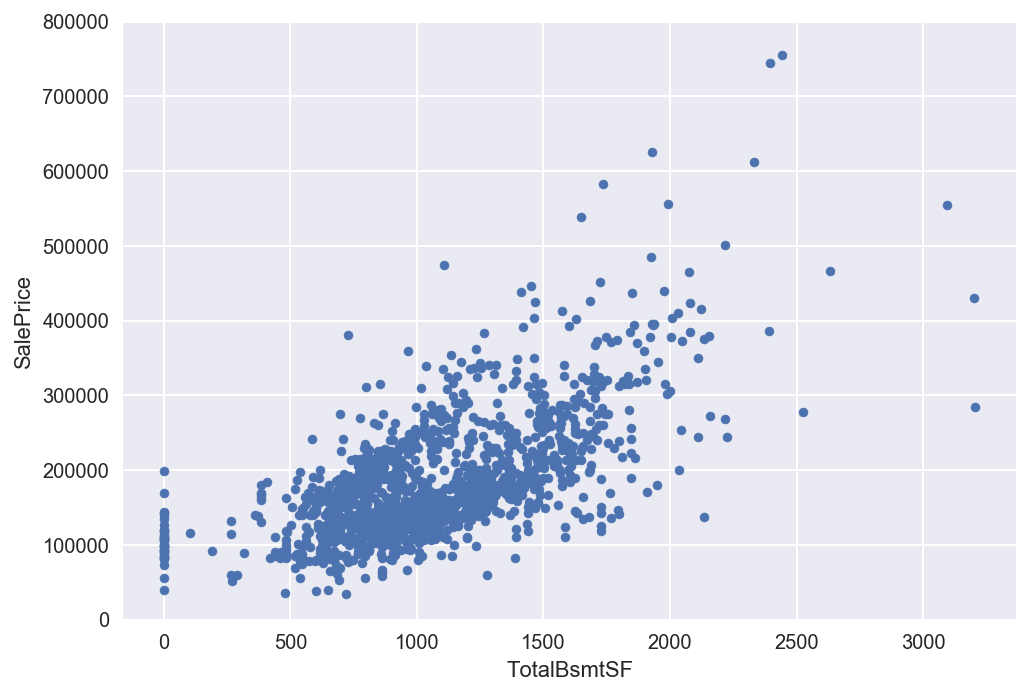

In [171]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

## 数据规约

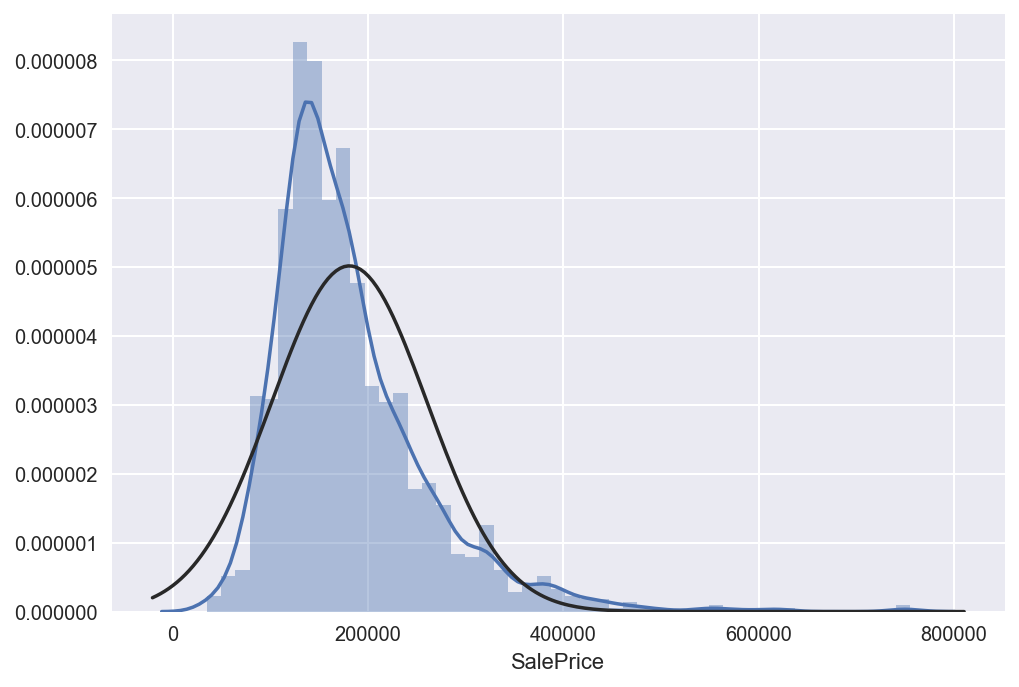

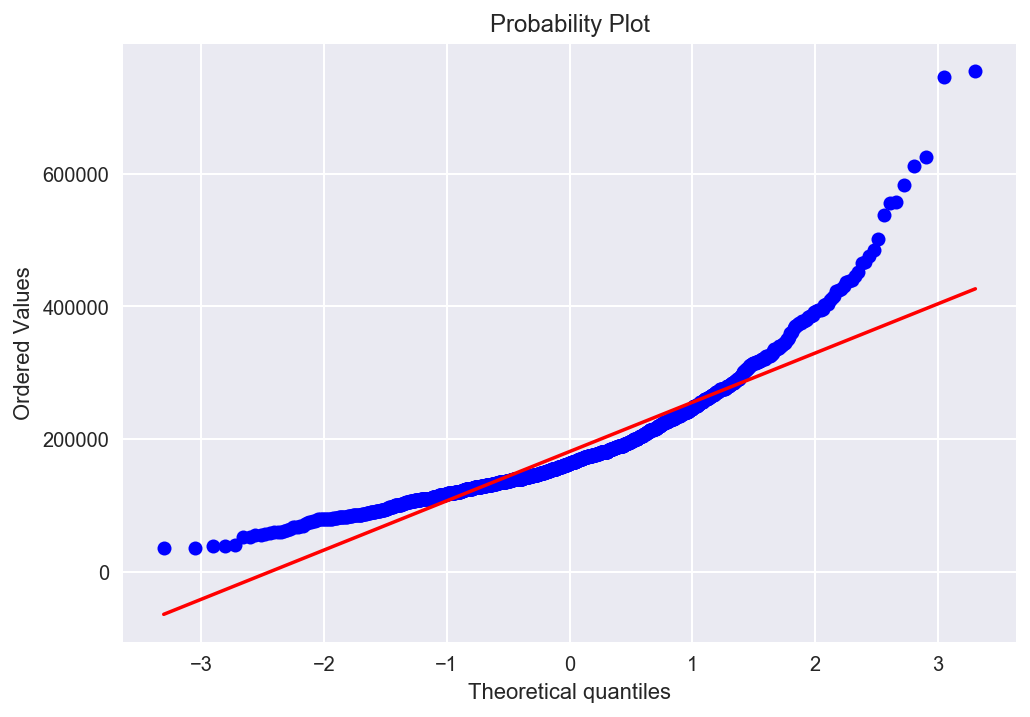

In [172]:
sns.distplot(df_train.SalePrice, fit=norm)
fig = plt.figure()
res = stats.probplot(df_train.SalePrice, plot=plt)

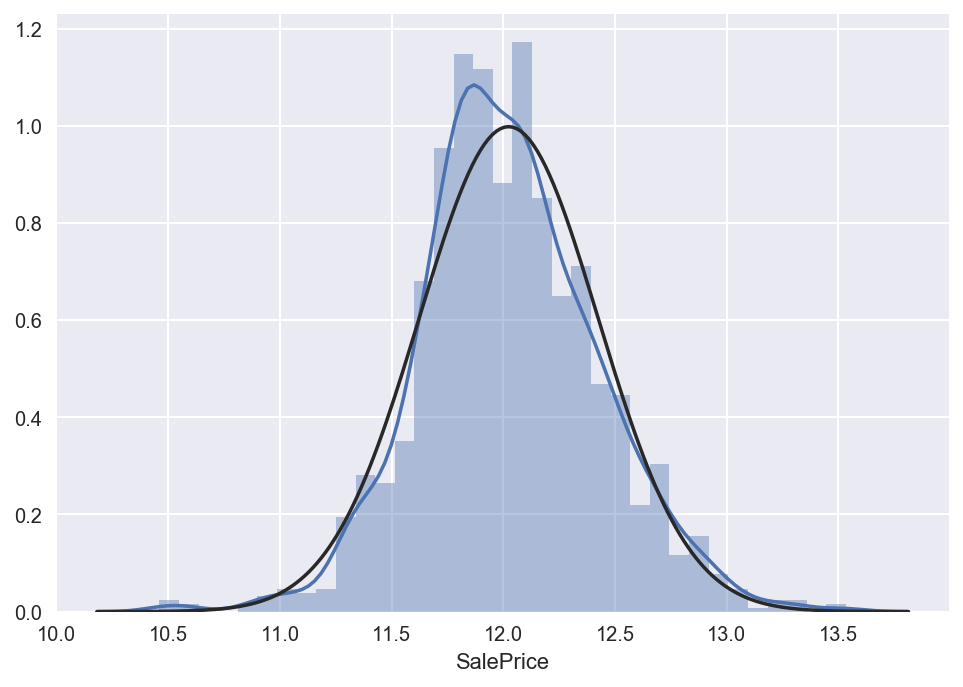

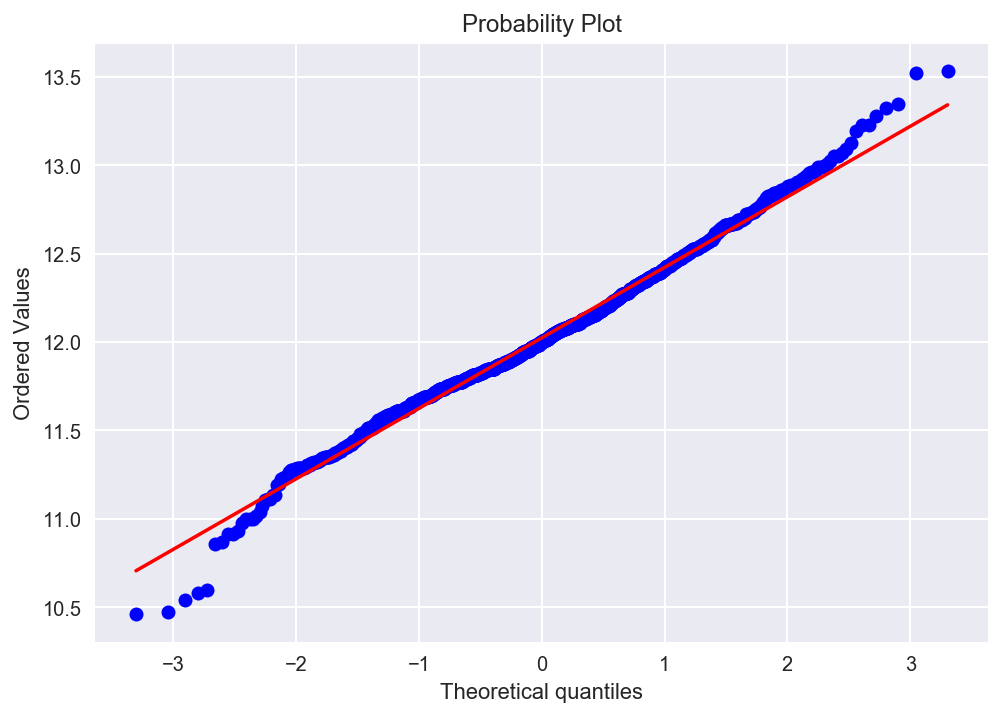

In [173]:
df_train.SalePrice = np.log(df_train.SalePrice)
sns.distplot(df_train.SalePrice, fit=norm)
fig = plt.figure()
res = stats.probplot(df_train.SalePrice, plot=plt)

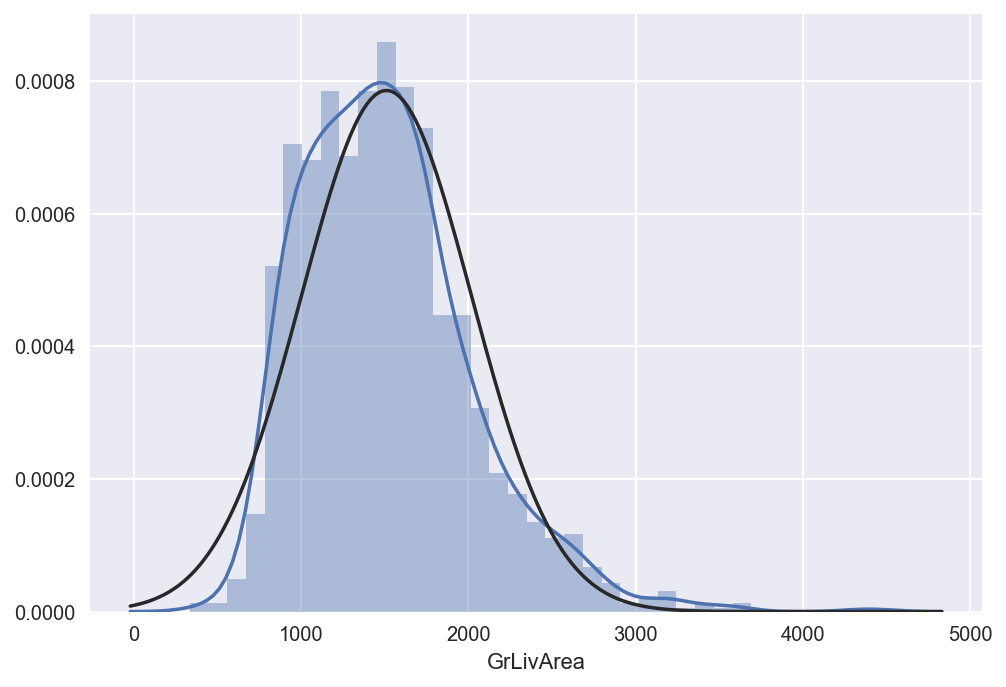

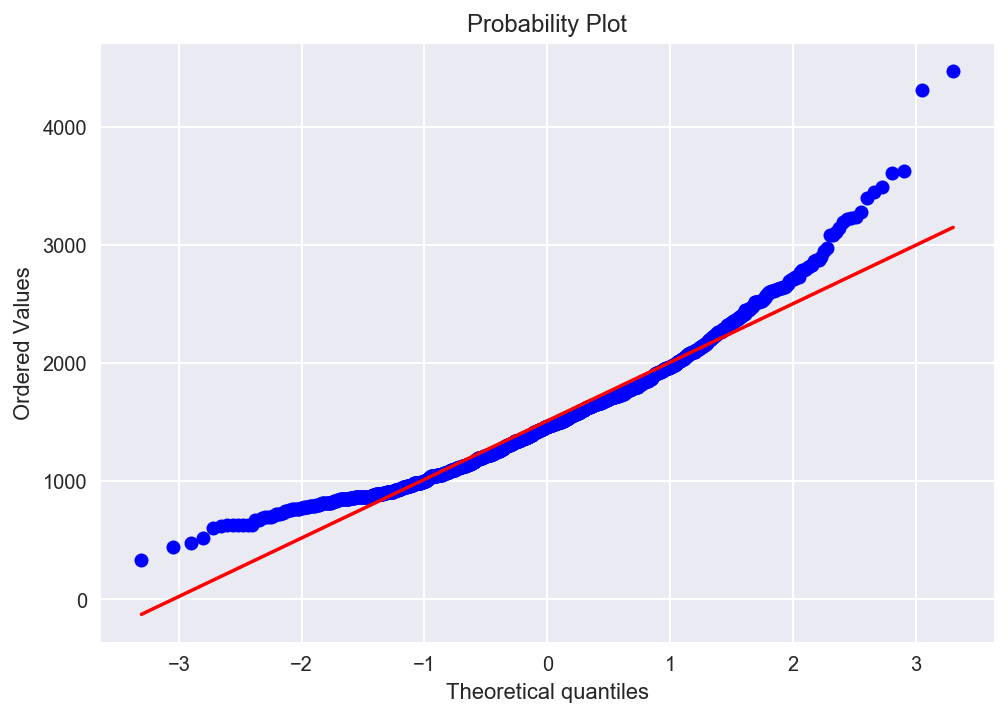

In [174]:
sns.distplot(df_train.GrLivArea, fit=norm)
fig = plt.figure()
res = stats.probplot(df_train.GrLivArea, plot=plt)

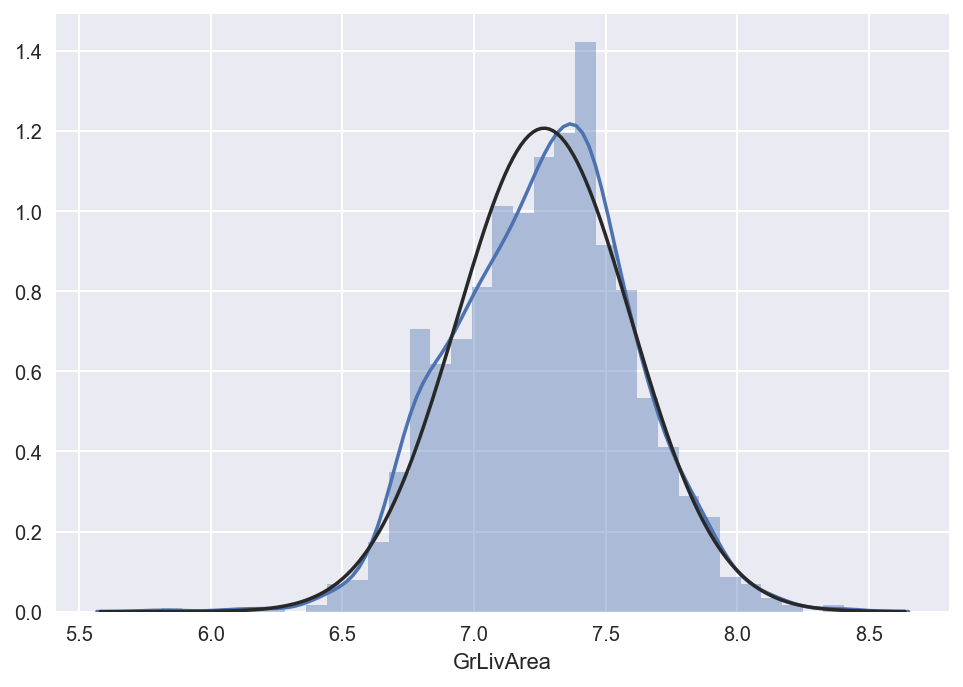

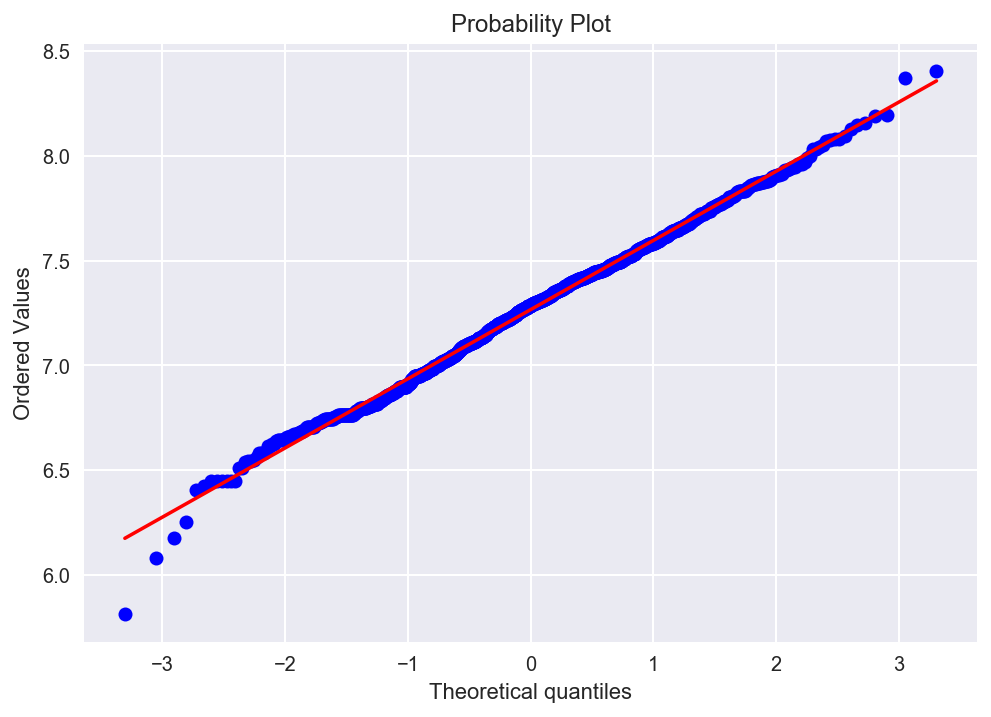

In [175]:
df_train.GrLivArea = np.log(df_train.GrLivArea)
sns.distplot(df_train.GrLivArea, fit=norm)
fig = plt.figure()
res = stats.probplot(df_train.GrLivArea, plot=plt)

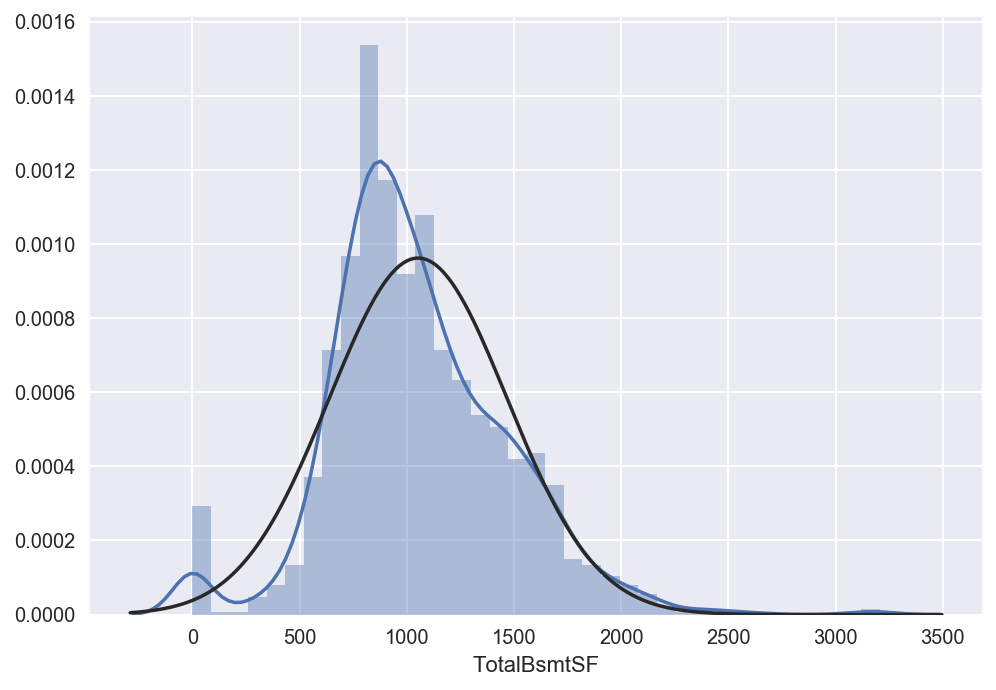

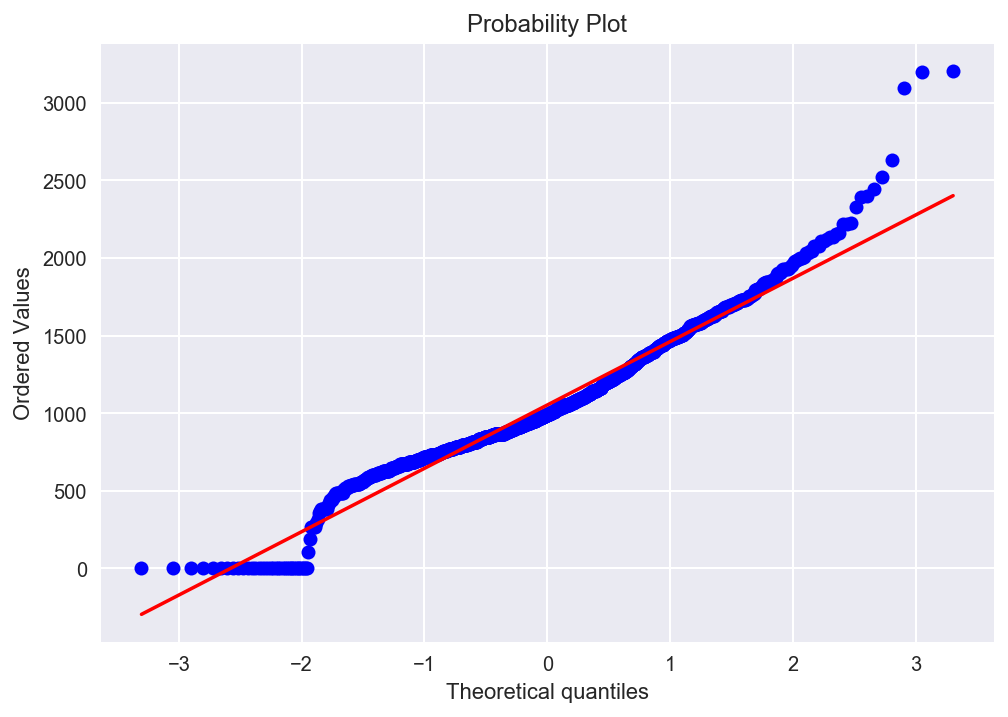

In [176]:
sns.distplot(df_train.TotalBsmtSF, fit=norm);
fig = plt.figure()
res = stats.probplot(df_train.TotalBsmtSF, plot=plt)

In [177]:
def trans(x):
    if x == 0:
        return 0
    else:
        return np.log(x)

In [178]:
df_train.TotalBsmtSF = df_train.TotalBsmtSF.apply(trans)

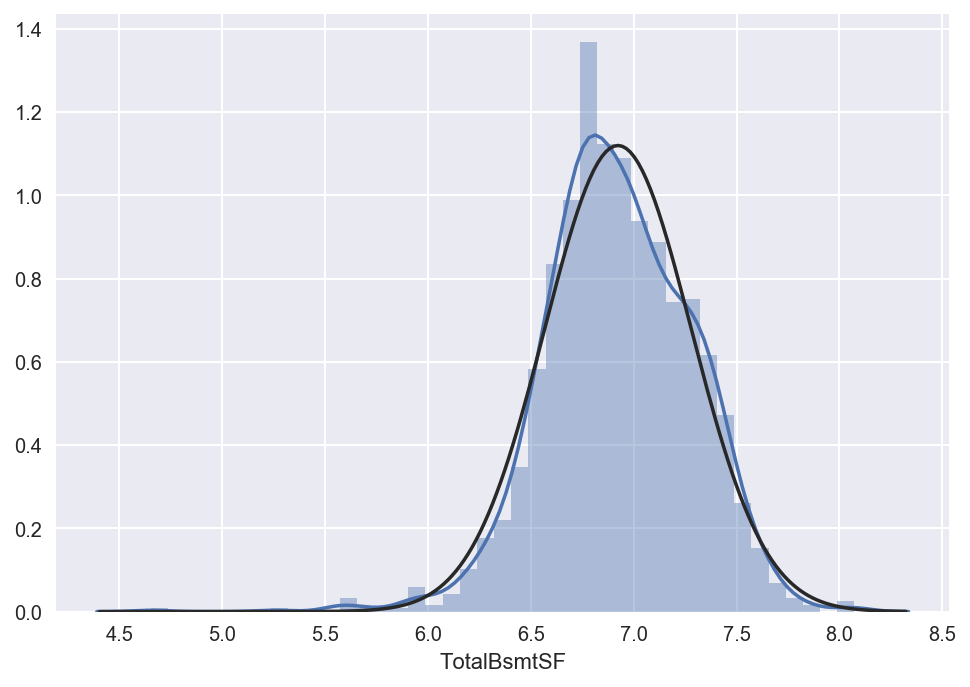

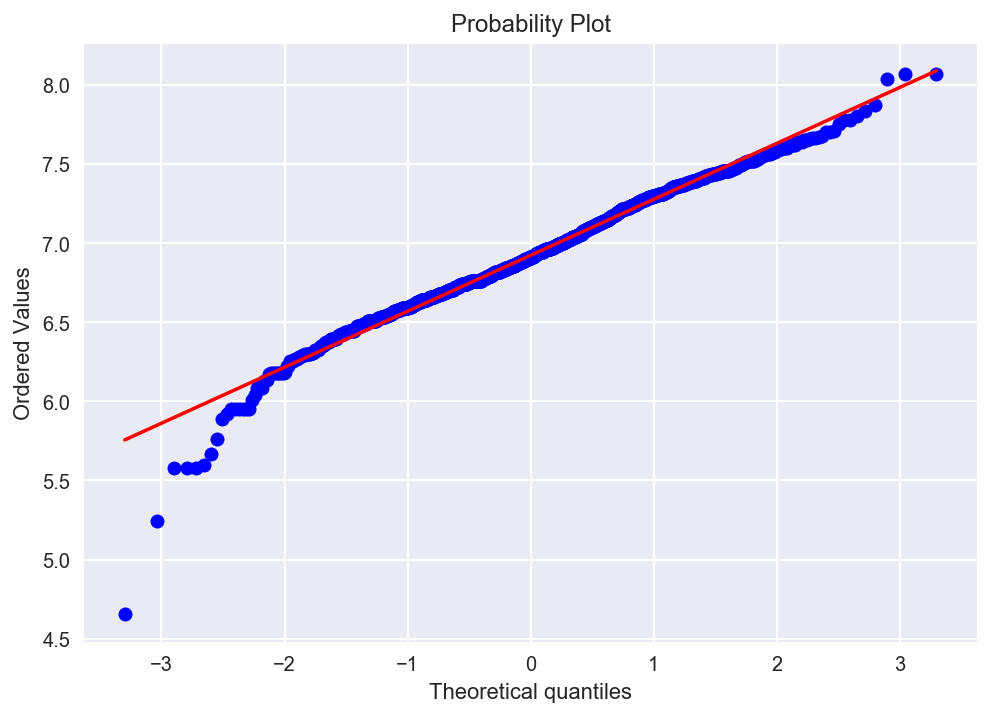

In [179]:
sns.distplot(df_train.TotalBsmtSF[df_train.TotalBsmtSF > 0], 
             fit=norm)
fig = plt.figure()
res = stats.probplot(df_train.TotalBsmtSF[df_train.TotalBsmtSF > 0],
                     plot=plt)

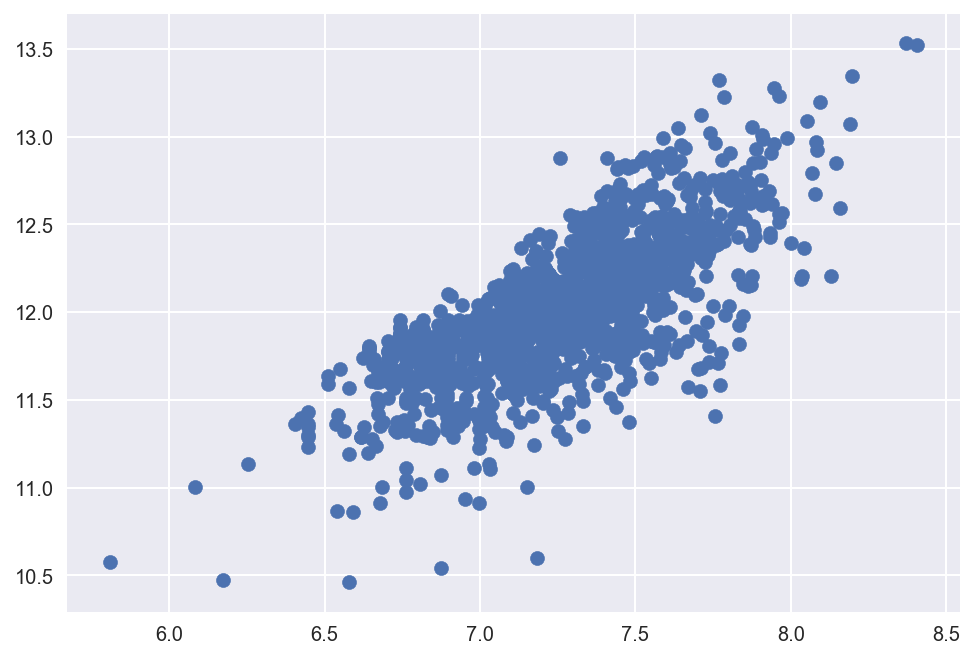

In [180]:
plt.scatter(df_train.GrLivArea, df_train.SalePrice)

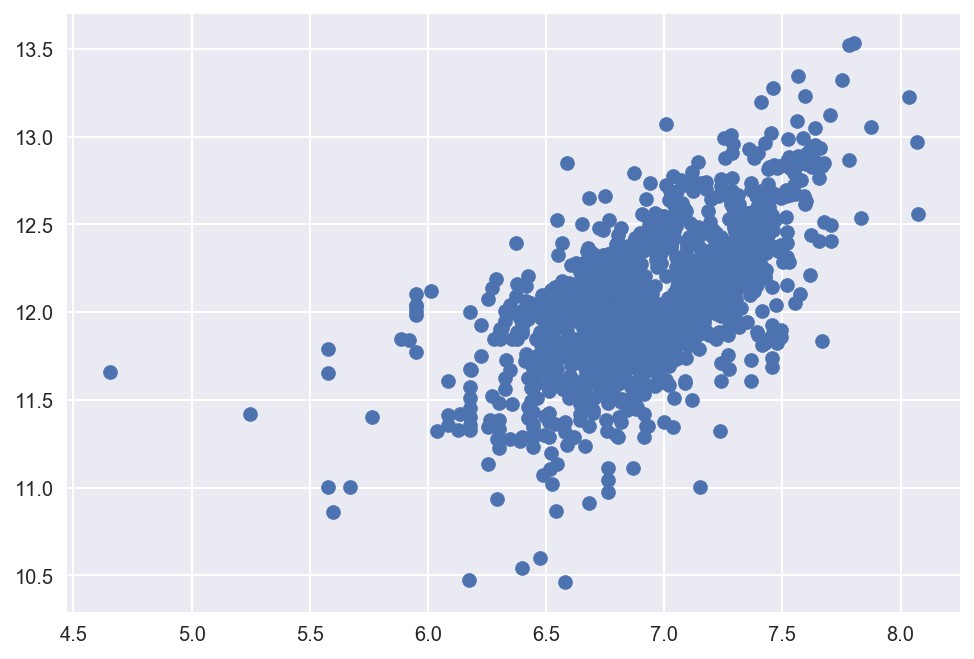

In [181]:
plt.scatter(df_train.TotalBsmtSF[df_train.TotalBsmtSF>0], 
            df_train.SalePrice[df_train.TotalBsmtSF>0])

In [198]:
beta = df_train
train = df_train.loc[:, :'SaleCondition']
y = df_train.loc[:, 'SalePrice']
train = pd.get_dummies(train)

In [199]:
#test
# cols
# total
# df_train.isnull().count()
# df_train.columns
# missing_data.index
# saleprice_scaled
# df_train.SalePrice[:, np.newaxis]
# df_train[df_train.Id == 234].index
# df_train.shape
# df_train.iloc[:, 35:]
# train.index
# df_train.SalePrice.index
# beta
train

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,0,1,0,0,0,0,1,0
5,6,50,14115,5,5,1993,1995,732,0,64,...,0,0,0,1,0,0,0,0,1,0
6,7,20,10084,8,5,2004,2005,1369,0,317,...,0,0,0,1,0,0,0,0,1,0
7,8,60,10382,7,6,1973,1973,859,32,216,...,0,0,0,1,0,0,0,0,1,0
8,9,50,6120,7,5,1931,1950,0,0,952,...,0,0,0,1,1,0,0,0,0,0
9,10,190,7420,5,6,1939,1950,851,0,140,...,0,0,0,1,0,0,0,0,1,0
